# Machine Learning Pipeline

In [465]:
################################################
# End-to-End Diabetes Machine Learning Pipeline I
################################################

In [466]:
# 1. Exploratory Data Analysis
# 2. Data Preprocessing & Feature Engineering
# 3. Base Models
# 4. Automated Hyperparameter Optimization
# 5. Stacking & Ensemble Learning
# 6. Prediction for a New Observation
# 7. Pipeline Main Function

In [467]:
# Kütüphanelerimizi import edelim;

import joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings

In [468]:
# pandas ayarlarımızı yapalım;

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore')

In [469]:
################################################
# 1. Exploratory Data Analysis
################################################

In [470]:
# EDA için fonksiyon tanımlayalım;

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    display(pd.DataFrame(dataframe.dtypes, columns=["DataType"]))
    print("##################### Head #####################")
    display(dataframe.head(head))
    print("##################### Tail #####################")
    display(dataframe.tail(head))
    print("##################### NA #####################")
    display(pd.DataFrame(dataframe.isnull().sum(), columns=["# of N/A value"]))
    print("##################### Quantiles #####################")
    display(pd.DataFrame(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T, 
                         columns=[0, 0.05, 0.50, 0.95, 0.99, 1]).round(2))

def cat_summary(dataframe, col_name, plot=False):
    display(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, 
                      vmin= -1, vmax= 1, annot_kws={'size': 12}, linecolor='w', cmap="RdBu")
    plt.show(block=True)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [471]:
df = pd.read_csv("datasets/diabetes.csv")

check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################


,DataType
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64
Outcome,int64


##################### Head #####################


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##################### Tail #####################


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


##################### NA #####################


,# of N/A value
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


##################### Quantiles #####################


,0.00,0.05,0.50,0.95,0.99,1.00
Pregnancies,0.00,0.00,3.00,10.00,13.00,17.00
Glucose,0.00,79.00,117.00,181.00,196.00,199.00
BloodPressure,0.00,38.70,72.00,90.00,106.00,122.00
SkinThickness,0.00,0.00,23.00,44.00,51.33,99.00
Insulin,0.00,0.00,30.50,293.00,519.90,846.00
BMI,0.00,21.80,32.00,44.40,50.76,67.10
DiabetesPedigreeFunction,0.08,0.14,0.37,1.13,1.70,2.42
Age,21.00,21.00,29.00,58.00,67.00,81.00
Outcome,0.00,0.00,0.00,1.00,1.00,1.00


In [472]:
# Değişken türlerinin ayrıştırılması
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

In [473]:
# Kategorik değişkenlerin incelenmesi
for col in cat_cols:
    cat_summary(df, col)

,Outcome,Ratio
0,500,65.104167
1,268,34.895833


##########################################


In [474]:
# Sayısal değişkenlerin incelenmesi
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


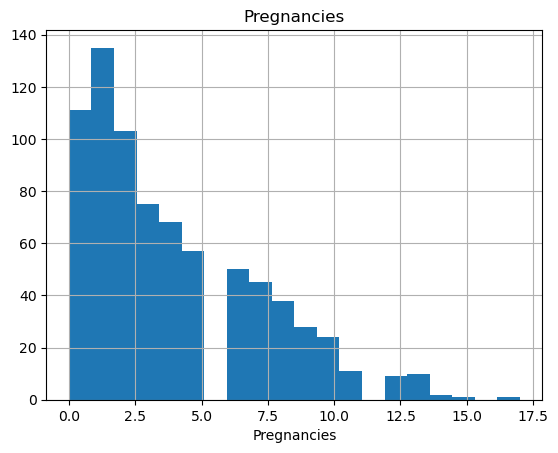

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


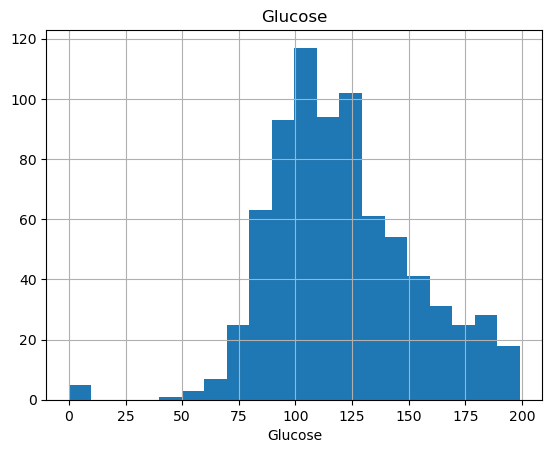

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


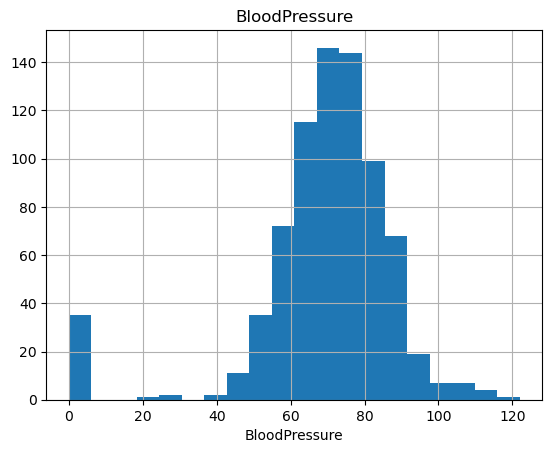

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


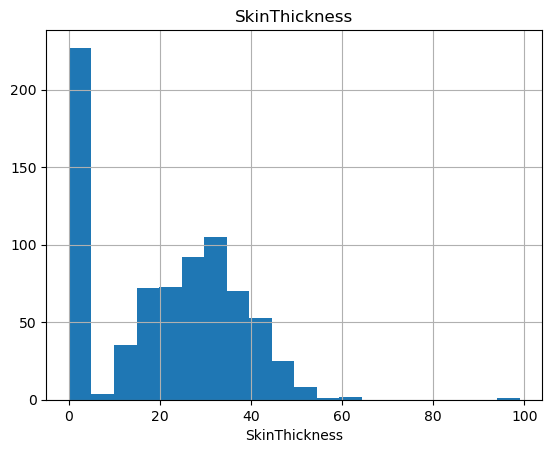

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


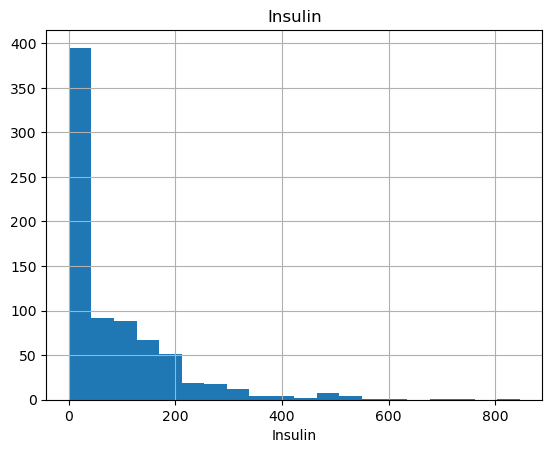

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


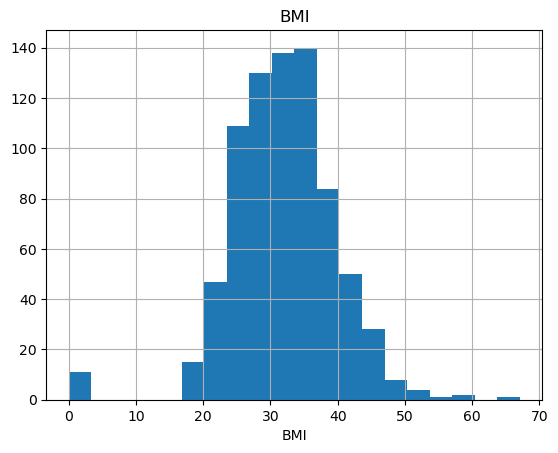

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


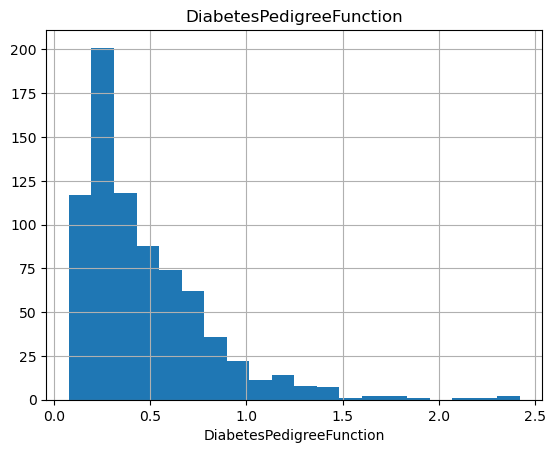

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


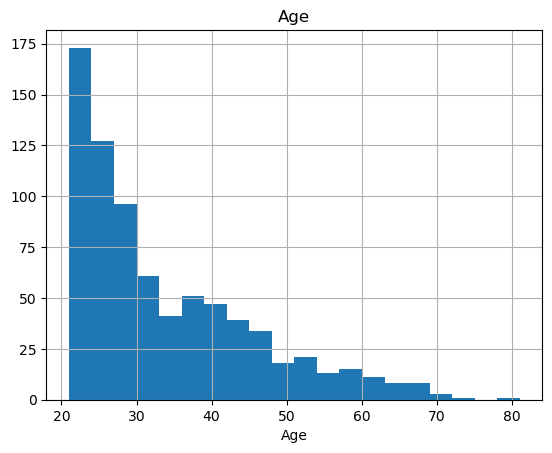

In [475]:
for col in num_cols:
    num_summary(df, col, plot=True)

    Yukarıdaki grafiklerden görülmektedir ki boş değerler büyük bir ihtimalle 0 ile doldurulmuş.

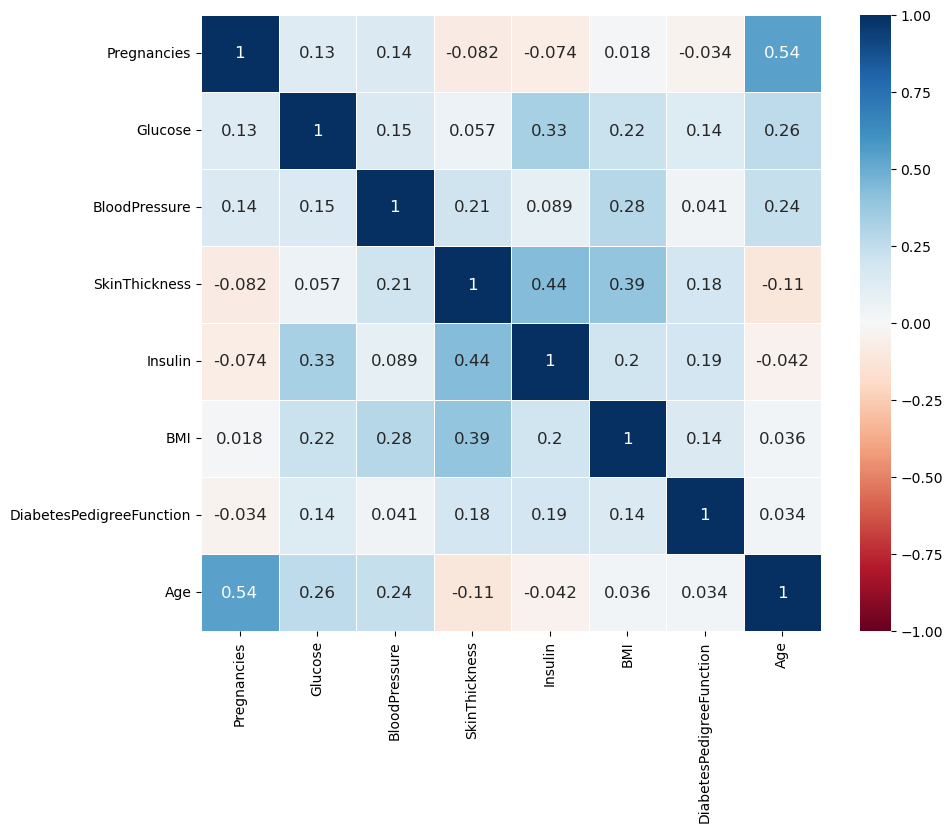

In [476]:
# Sayısal değişkenkerin birbirleri ile korelasyonu
correlation_matrix(df, num_cols)

In [477]:
# Target ile sayısal değişkenlerin incelemesi
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




In [478]:
################################################
# 2. Data Preprocessing & Feature Engineering
################################################

In [479]:
# Fonksiyonlarımızı tanımlayalım;

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [480]:
# Değişken isimleri büyütmek
df.columns = [col.upper() for col in df.columns]

In [481]:
# Glucose
df['NEW_GLUCOSE_CAT'] = pd.cut(x=df['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])
df

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes
1,1,85,66,29,0,26.6,0.351,31,0,normal
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes
3,1,89,66,23,94,28.1,0.167,21,0,normal
4,0,137,40,35,168,43.1,2.288,33,1,normal
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,normal
764,2,122,70,27,0,36.8,0.340,27,0,normal
765,5,121,72,23,112,26.2,0.245,30,0,normal
766,1,126,60,0,0,30.1,0.349,47,1,normal


In [482]:
# Age
df.loc[(df['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
df.loc[(df['AGE'] >= 35) & (df['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
df.loc[(df['AGE'] > 55), "NEW_AGE_CAT"] = 'old'
df

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT,NEW_AGE_CAT
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes,middleage
1,1,85,66,29,0,26.6,0.351,31,0,normal,young
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes,young
3,1,89,66,23,94,28.1,0.167,21,0,normal,young
4,0,137,40,35,168,43.1,2.288,33,1,normal,young
...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,normal,old
764,2,122,70,27,0,36.8,0.340,27,0,normal,young
765,5,121,72,23,112,26.2,0.245,30,0,normal,young
766,1,126,60,0,0,30.1,0.349,47,1,normal,middleage


In [483]:
# BMI
df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                             labels=["underweight", "healty", "overweight", "obese"])
df

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT,NEW_AGE_CAT,NEW_BMI_RANGE
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes,middleage,obese
1,1,85,66,29,0,26.6,0.351,31,0,normal,young,overweight
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes,young,healty
3,1,89,66,23,94,28.1,0.167,21,0,normal,young,overweight
4,0,137,40,35,168,43.1,2.288,33,1,normal,young,obese
...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,normal,old,obese
764,2,122,70,27,0,36.8,0.340,27,0,normal,young,obese
765,5,121,72,23,112,26.2,0.245,30,0,normal,young,overweight
766,1,126,60,0,0,30.1,0.349,47,1,normal,middleage,obese


In [484]:
# BloodPressure
df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels=["normal", "hs1", "hs2"])
df

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT,NEW_AGE_CAT,NEW_BMI_RANGE,NEW_BLOODPRESSURE
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes,middleage,obese,normal
1,1,85,66,29,0,26.6,0.351,31,0,normal,young,overweight,normal
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes,young,healty,normal
3,1,89,66,23,94,28.1,0.167,21,0,normal,young,overweight,normal
4,0,137,40,35,168,43.1,2.288,33,1,normal,young,obese,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,normal,old,obese,normal
764,2,122,70,27,0,36.8,0.340,27,0,normal,young,obese,normal
765,5,121,72,23,112,26.2,0.245,30,0,normal,young,overweight,normal
766,1,126,60,0,0,30.1,0.349,47,1,normal,middleage,obese,normal


In [485]:
# veri setimizi kontrol edelim;

check_df(df)


##################### Shape #####################
(768, 13)
##################### Types #####################


,DataType
PREGNANCIES,int64
GLUCOSE,int64
BLOODPRESSURE,int64
SKINTHICKNESS,int64
INSULIN,int64
BMI,float64
DIABETESPEDIGREEFUNCTION,float64
AGE,int64
OUTCOME,int64
NEW_GLUCOSE_CAT,category


##################### Head #####################


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT,NEW_AGE_CAT,NEW_BMI_RANGE,NEW_BLOODPRESSURE
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes,middleage,obese,normal
1,1,85,66,29,0,26.6,0.351,31,0,normal,young,overweight,normal
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes,young,healty,normal
3,1,89,66,23,94,28.1,0.167,21,0,normal,young,overweight,normal
4,0,137,40,35,168,43.1,2.288,33,1,normal,young,obese,normal


##################### Tail #####################


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT,NEW_AGE_CAT,NEW_BMI_RANGE,NEW_BLOODPRESSURE
763,10,101,76,48,180,32.9,0.171,63,0,normal,old,obese,normal
764,2,122,70,27,0,36.8,0.340,27,0,normal,young,obese,normal
765,5,121,72,23,112,26.2,0.245,30,0,normal,young,overweight,normal
766,1,126,60,0,0,30.1,0.349,47,1,normal,middleage,obese,normal
767,1,93,70,31,0,30.4,0.315,23,0,normal,young,obese,normal


##################### NA #####################


,# of N/A value
PREGNANCIES,0
GLUCOSE,0
BLOODPRESSURE,0
SKINTHICKNESS,0
INSULIN,0
BMI,0
DIABETESPEDIGREEFUNCTION,0
AGE,0
OUTCOME,0
NEW_GLUCOSE_CAT,0


##################### Quantiles #####################


,0.00,0.05,0.50,0.95,0.99,1.00
PREGNANCIES,0.00,0.00,3.00,10.00,13.00,17.00
GLUCOSE,0.00,79.00,117.00,181.00,196.00,199.00
BLOODPRESSURE,0.00,38.70,72.00,90.00,106.00,122.00
SKINTHICKNESS,0.00,0.00,23.00,44.00,51.33,99.00
INSULIN,0.00,0.00,30.50,293.00,519.90,846.00
BMI,0.00,21.80,32.00,44.40,50.76,67.10
DIABETESPEDIGREEFUNCTION,0.08,0.14,0.37,1.13,1.70,2.42
AGE,21.00,21.00,29.00,58.00,67.00,81.00
OUTCOME,0.00,0.00,0.00,1.00,1.00,1.00


Yukarıda bir takım değişkeneler ürettik ve NA değerlerimiz hala 0 olarak görülüyor. Her şey yoludna gibi.

In [486]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

In [487]:
# Yeni kategorik değişkenlerin dağılımına bakalım;

for col in cat_cols:
    cat_summary(df, col)

,NEW_AGE_CAT,Ratio
young,488,63.541667
middleage,230,29.947917
old,50,6.510417


##########################################


,OUTCOME,Ratio
0,500,65.104167
1,268,34.895833


##########################################


,NEW_GLUCOSE_CAT,Ratio
normal,571,74.348958
prediabetes,197,25.651042


##########################################


,NEW_BMI_RANGE,Ratio
obese,472,61.458333
overweight,179,23.307292
healty,102,13.281250
underweight,15,1.953125


##########################################


,NEW_BLOODPRESSURE,Ratio
normal,563,73.307292
hs1,145,18.880208
hs2,60,7.812500


##########################################


In [488]:
# Yeni kategorik değişkenlerin hedef değişkenle durumuna bakalım;

for col in cat_cols:
    target_summary_with_cat(df, "OUTCOME", col)

             TARGET_MEAN
NEW_AGE_CAT             
middleage       0.543478
old             0.340000
young           0.258197


         TARGET_MEAN
OUTCOME             
0                0.0
1                1.0


                 TARGET_MEAN
NEW_GLUCOSE_CAT             
normal              0.232925
prediabetes         0.685279


               TARGET_MEAN
NEW_BMI_RANGE             
underweight       0.133333
healty            0.068627
overweight        0.223464
obese             0.463983


                   TARGET_MEAN
NEW_BLOODPRESSURE             
normal                0.316163
hs1                   0.420690
hs2                   0.483333




In [489]:
# "OUTCOME" da bir cat değişken, lakin cat_cols'dan çıkarmak istersek;

cat_cols = [col for col in cat_cols if "OUTCOME" not in col]
cat_cols

['NEW_AGE_CAT', 'NEW_GLUCOSE_CAT', 'NEW_BMI_RANGE', 'NEW_BLOODPRESSURE']

In [490]:
# cat_cols'ları one hot encode edersek;

df = one_hot_encoder(df, cat_cols, drop_first=True)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT_old,NEW_AGE_CAT_young,NEW_GLUCOSE_CAT_prediabetes,NEW_BMI_RANGE_healty,NEW_BMI_RANGE_overweight,NEW_BMI_RANGE_obese,NEW_BLOODPRESSURE_hs1,NEW_BLOODPRESSURE_hs2
0,6,148,72,35,0,33.6,0.627,50,1,0,0,1,0,0,1,0,0
1,1,85,66,29,0,26.6,0.351,31,0,0,1,0,0,1,0,0,0
2,8,183,64,0,0,23.3,0.672,32,1,0,1,1,1,0,0,0,0
3,1,89,66,23,94,28.1,0.167,21,0,0,1,0,0,1,0,0,0
4,0,137,40,35,168,43.1,2.288,33,1,0,1,0,0,0,1,0,0


In [491]:
# Her şey yolunda mı diye kontrol edelim

check_df(df)

##################### Shape #####################
(768, 17)
##################### Types #####################


,DataType
PREGNANCIES,int64
GLUCOSE,int64
BLOODPRESSURE,int64
SKINTHICKNESS,int64
INSULIN,int64
BMI,float64
DIABETESPEDIGREEFUNCTION,float64
AGE,int64
OUTCOME,int64
NEW_AGE_CAT_old,uint8


##################### Head #####################


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT_old,NEW_AGE_CAT_young,NEW_GLUCOSE_CAT_prediabetes,NEW_BMI_RANGE_healty,NEW_BMI_RANGE_overweight,NEW_BMI_RANGE_obese,NEW_BLOODPRESSURE_hs1,NEW_BLOODPRESSURE_hs2
0,6,148,72,35,0,33.6,0.627,50,1,0,0,1,0,0,1,0,0
1,1,85,66,29,0,26.6,0.351,31,0,0,1,0,0,1,0,0,0
2,8,183,64,0,0,23.3,0.672,32,1,0,1,1,1,0,0,0,0
3,1,89,66,23,94,28.1,0.167,21,0,0,1,0,0,1,0,0,0
4,0,137,40,35,168,43.1,2.288,33,1,0,1,0,0,0,1,0,0


##################### Tail #####################


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT_old,NEW_AGE_CAT_young,NEW_GLUCOSE_CAT_prediabetes,NEW_BMI_RANGE_healty,NEW_BMI_RANGE_overweight,NEW_BMI_RANGE_obese,NEW_BLOODPRESSURE_hs1,NEW_BLOODPRESSURE_hs2
763,10,101,76,48,180,32.9,0.171,63,0,1,0,0,0,0,1,0,0
764,2,122,70,27,0,36.8,0.340,27,0,0,1,0,0,0,1,0,0
765,5,121,72,23,112,26.2,0.245,30,0,0,1,0,0,1,0,0,0
766,1,126,60,0,0,30.1,0.349,47,1,0,0,0,0,0,1,0,0
767,1,93,70,31,0,30.4,0.315,23,0,0,1,0,0,0,1,0,0


##################### NA #####################


,# of N/A value
PREGNANCIES,0
GLUCOSE,0
BLOODPRESSURE,0
SKINTHICKNESS,0
INSULIN,0
BMI,0
DIABETESPEDIGREEFUNCTION,0
AGE,0
OUTCOME,0
NEW_AGE_CAT_old,0


##################### Quantiles #####################


,0.00,0.05,0.50,0.95,0.99,1.00
PREGNANCIES,0.00,0.00,3.00,10.00,13.00,17.00
GLUCOSE,0.00,79.00,117.00,181.00,196.00,199.00
BLOODPRESSURE,0.00,38.70,72.00,90.00,106.00,122.00
SKINTHICKNESS,0.00,0.00,23.00,44.00,51.33,99.00
INSULIN,0.00,0.00,30.50,293.00,519.90,846.00
BMI,0.00,21.80,32.00,44.40,50.76,67.10
DIABETESPEDIGREEFUNCTION,0.08,0.14,0.37,1.13,1.70,2.42
AGE,21.00,21.00,29.00,58.00,67.00,81.00
OUTCOME,0.00,0.00,0.00,1.00,1.00,1.00
NEW_AGE_CAT_old,0.00,0.00,0.00,1.00,1.00,1.00


In [492]:
# Aynı formatta olsun düye sütun isimlerimizi büyütelim;

df.columns = [col.upper() for col in df.columns]

In [493]:
# Son güncel değişken türlerimizi yakalayalım;

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

In [494]:
# Aykırı değer var mı kontrol edelim;

for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


        Yukarıda, insulin değerinde aykırı değer olduğunu görüyoruz.

In [495]:
# Bu aykırı değerleri traşlayalım;
replace_with_thresholds(df, "INSULIN")

In [496]:
# Değişkenlerde standartlaştırma yapalım;

X_scaled = StandardScaler().fit_transform(df[num_cols])
X_scaled

# X_scaled numpy array'i olarak döndü.

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.20401277,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.68442195,
        -0.36506078, -0.19067191],
       [ 1.23388019,  1.94372388, -0.26394125, ..., -1.10325546,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.73518964,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.24020459,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.20212881,
        -0.47378505, -0.87137393]])

In [497]:
# Bu array'i dataframe olarak hatta df'nin içerisine kaydedelim;

df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)
df

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_GLUCOSE_CAT_PREDIABETES,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
0,0.639947,0.848324,0.149641,0.907270,-0.787602,0.204013,0.468492,1.425995,1,0,0,1,0,0,1,0,0
1,-0.844885,-1.123396,-0.160546,0.530902,-0.787602,-0.684422,-0.365061,-0.190672,0,0,1,0,0,1,0,0,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.787602,-1.103255,0.604397,-0.105584,1,0,1,1,1,0,0,0,0
3,-0.844885,-0.998208,-0.160546,0.154533,0.217583,-0.494043,-0.920763,-1.041549,0,0,1,0,0,1,0,0,0
4,-1.141852,0.504055,-1.504687,0.907270,1.008900,1.409746,5.484909,-0.020496,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1.827813,-0.622642,0.356432,1.722735,1.137221,0.115169,-0.908682,2.532136,0,1,0,0,0,0,1,0,0
764,-0.547919,0.034598,0.046245,0.405445,-0.787602,0.610154,-0.398282,-0.531023,0,0,1,0,0,0,1,0,0
765,0.342981,0.003301,0.149641,0.154533,0.410066,-0.735190,-0.685193,-0.275760,0,0,1,0,0,1,0,0,0
766,-0.844885,0.159787,-0.470732,-1.288212,-0.787602,-0.240205,-0.371101,1.170732,1,0,0,0,0,0,1,0,0


In [498]:
# Bağımlı ve bağımsız değişkenlerimizi tanımlayalım;

y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)

In [499]:
# Bağımsız değişkenlerimizi check edelim;

check_df(X)

##################### Shape #####################
(768, 16)
##################### Types #####################


,DataType
PREGNANCIES,float64
GLUCOSE,float64
BLOODPRESSURE,float64
SKINTHICKNESS,float64
INSULIN,float64
BMI,float64
DIABETESPEDIGREEFUNCTION,float64
AGE,float64
NEW_AGE_CAT_OLD,uint8
NEW_AGE_CAT_YOUNG,uint8


##################### Head #####################


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_GLUCOSE_CAT_PREDIABETES,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
0,0.639947,0.848324,0.149641,0.907270,-0.787602,0.204013,0.468492,1.425995,0,0,1,0,0,1,0,0
1,-0.844885,-1.123396,-0.160546,0.530902,-0.787602,-0.684422,-0.365061,-0.190672,0,1,0,0,1,0,0,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.787602,-1.103255,0.604397,-0.105584,0,1,1,1,0,0,0,0
3,-0.844885,-0.998208,-0.160546,0.154533,0.217583,-0.494043,-0.920763,-1.041549,0,1,0,0,1,0,0,0
4,-1.141852,0.504055,-1.504687,0.907270,1.008900,1.409746,5.484909,-0.020496,0,1,0,0,0,1,0,0


##################### Tail #####################


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_GLUCOSE_CAT_PREDIABETES,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
763,1.827813,-0.622642,0.356432,1.722735,1.137221,0.115169,-0.908682,2.532136,1,0,0,0,0,1,0,0
764,-0.547919,0.034598,0.046245,0.405445,-0.787602,0.610154,-0.398282,-0.531023,0,1,0,0,0,1,0,0
765,0.342981,0.003301,0.149641,0.154533,0.410066,-0.735190,-0.685193,-0.275760,0,1,0,0,1,0,0,0
766,-0.844885,0.159787,-0.470732,-1.288212,-0.787602,-0.240205,-0.371101,1.170732,0,0,0,0,0,1,0,0
767,-0.844885,-0.873019,0.046245,0.656358,-0.787602,-0.202129,-0.473785,-0.871374,0,1,0,0,0,1,0,0


##################### NA #####################


,# of N/A value
PREGNANCIES,0
GLUCOSE,0
BLOODPRESSURE,0
SKINTHICKNESS,0
INSULIN,0
BMI,0
DIABETESPEDIGREEFUNCTION,0
AGE,0
NEW_AGE_CAT_OLD,0
NEW_AGE_CAT_YOUNG,0


##################### Quantiles #####################


,0.00,0.05,0.50,0.95,0.99,1.00
PREGNANCIES,-1.14,-1.14,-0.25,1.83,2.72,3.91
GLUCOSE,-3.78,-1.31,-0.12,1.88,2.35,2.44
BLOODPRESSURE,-3.57,-1.57,0.15,1.08,1.91,2.73
SKINTHICKNESS,-1.29,-1.29,0.15,1.47,1.93,4.92
INSULIN,-0.79,-0.79,-0.46,2.35,2.61,2.61
BMI,-4.06,-1.29,0.00,1.57,2.38,4.46
DIABETESPEDIGREEFUNCTION,-1.19,-1.00,-0.30,2.00,3.70,5.88
AGE,-1.04,-1.04,-0.36,2.11,2.87,4.06
NEW_AGE_CAT_OLD,0.00,0.00,0.00,1.00,1.00,1.00
NEW_AGE_CAT_YOUNG,0.00,0.00,1.00,1.00,1.00,1.00


In [500]:
# Bütün bu süreci bu case bazında fonksiyonlaştırmak istersek;

def diabetes_data_prep(dataframe):
    dataframe.columns = [col.upper() for col in dataframe.columns]

    # Glucose
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

    # Age
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

    # BMI
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

    # BloodPressure
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    df.columns = [col.upper() for col in df.columns]

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    replace_with_thresholds(df, "INSULIN")

    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y


In [501]:
# Baştan verimizi okutalım;
df = pd.read_csv("datasets/diabetes.csv")

# Verimizi kontrol edelim;
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################


,DataType
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64
Outcome,int64


##################### Head #####################


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##################### Tail #####################


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


##################### NA #####################


,# of N/A value
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


##################### Quantiles #####################


,0.00,0.05,0.50,0.95,0.99,1.00
Pregnancies,0.00,0.00,3.00,10.00,13.00,17.00
Glucose,0.00,79.00,117.00,181.00,196.00,199.00
BloodPressure,0.00,38.70,72.00,90.00,106.00,122.00
SkinThickness,0.00,0.00,23.00,44.00,51.33,99.00
Insulin,0.00,0.00,30.50,293.00,519.90,846.00
BMI,0.00,21.80,32.00,44.40,50.76,67.10
DiabetesPedigreeFunction,0.08,0.14,0.37,1.13,1.70,2.42
Age,21.00,21.00,29.00,58.00,67.00,81.00
Outcome,0.00,0.00,0.00,1.00,1.00,1.00


In [502]:
# df'yi hazırladığımız fonksiyondan geçirelim;
X, y = diabetes_data_prep(df)

# Kontrolünü sağlayalım;
check_df(X)

##################### Shape #####################
(768, 16)
##################### Types #####################


,DataType
PREGNANCIES,float64
GLUCOSE,float64
BLOODPRESSURE,float64
SKINTHICKNESS,float64
INSULIN,float64
BMI,float64
DIABETESPEDIGREEFUNCTION,float64
AGE,float64
NEW_AGE_CAT_OLD,uint8
NEW_AGE_CAT_YOUNG,uint8


##################### Head #####################


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_GLUCOSE_CAT_PREDIABETES,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
0,0.639947,0.848324,0.149641,0.907270,-0.787602,0.204013,0.468492,1.425995,0,0,1,0,0,1,0,0
1,-0.844885,-1.123396,-0.160546,0.530902,-0.787602,-0.684422,-0.365061,-0.190672,0,1,0,0,1,0,0,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.787602,-1.103255,0.604397,-0.105584,0,1,1,1,0,0,0,0
3,-0.844885,-0.998208,-0.160546,0.154533,0.217583,-0.494043,-0.920763,-1.041549,0,1,0,0,1,0,0,0
4,-1.141852,0.504055,-1.504687,0.907270,1.008900,1.409746,5.484909,-0.020496,0,1,0,0,0,1,0,0


##################### Tail #####################


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_GLUCOSE_CAT_PREDIABETES,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
763,1.827813,-0.622642,0.356432,1.722735,1.137221,0.115169,-0.908682,2.532136,1,0,0,0,0,1,0,0
764,-0.547919,0.034598,0.046245,0.405445,-0.787602,0.610154,-0.398282,-0.531023,0,1,0,0,0,1,0,0
765,0.342981,0.003301,0.149641,0.154533,0.410066,-0.735190,-0.685193,-0.275760,0,1,0,0,1,0,0,0
766,-0.844885,0.159787,-0.470732,-1.288212,-0.787602,-0.240205,-0.371101,1.170732,0,0,0,0,0,1,0,0
767,-0.844885,-0.873019,0.046245,0.656358,-0.787602,-0.202129,-0.473785,-0.871374,0,1,0,0,0,1,0,0


##################### NA #####################


,# of N/A value
PREGNANCIES,0
GLUCOSE,0
BLOODPRESSURE,0
SKINTHICKNESS,0
INSULIN,0
BMI,0
DIABETESPEDIGREEFUNCTION,0
AGE,0
NEW_AGE_CAT_OLD,0
NEW_AGE_CAT_YOUNG,0


##################### Quantiles #####################


,0.00,0.05,0.50,0.95,0.99,1.00
PREGNANCIES,-1.14,-1.14,-0.25,1.83,2.72,3.91
GLUCOSE,-3.78,-1.31,-0.12,1.88,2.35,2.44
BLOODPRESSURE,-3.57,-1.57,0.15,1.08,1.91,2.73
SKINTHICKNESS,-1.29,-1.29,0.15,1.47,1.93,4.92
INSULIN,-0.79,-0.79,-0.46,2.35,2.61,2.61
BMI,-4.06,-1.29,0.00,1.57,2.38,4.46
DIABETESPEDIGREEFUNCTION,-1.19,-1.00,-0.30,2.00,3.70,5.88
AGE,-1.04,-1.04,-0.36,2.11,2.87,4.06
NEW_AGE_CAT_OLD,0.00,0.00,0.00,1.00,1.00,1.00
NEW_AGE_CAT_YOUNG,0.00,0.00,1.00,1.00,1.00,1.00


    Bilindiği üzere makine öğrenmesinde bir çok farklı aşama mevcuttur. 
    
        * Verinin toplanması
        * Veri ön işleme aşamaları; dealing wiht outliers & missing values
        * Feature engineering
        * Modelleme vs.

    Bu her bir adımı modüler hale getirme işlemine pipeline diyeceğiz. Yani boru oluşturma. Oluşturduğumuz her bir boru ile, oluşan çıktı diğer pipeline için girdi olacak.

    Yukarıda oluşturduğumuz "diabetes_data_prep()" fonksiyonu ile veri ön işleme kısmının pipeline'sini oluşturmuş bulunduk. 

Yeni veri geldiğinde yukarıda yaptığımız işlemin yeniden yapmamıza gerek kalmadan sadece fonksiyodan geçirmemiz yeterli olacak.

In [503]:
######################################################
# 3. Base Models
######################################################

# Bu bölümde base modellerimizin fikrini almak adına bir fonksiyon tanımlayacağız.

In [504]:
# Fonksiyonumuzu tanımlayalım;

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")
    
# catboost'un çalışması uzun sürdüğü için yukarıda commentlenmiştir.

In [505]:
base_models(X, y, scoring="roc_auc")

Base Models....
roc_auc: 0.8409 (LR) 
roc_auc: 0.791 (KNN) 
roc_auc: 0.8355 (SVC) 
roc_auc: 0.6512 (CART) 
roc_auc: 0.8304 (RF) 
roc_auc: 0.8196 (Adaboost) 
roc_auc: 0.8247 (GBM) 
roc_auc: 0.8015 (XGBoost) 
roc_auc: 0.807 (LightGBM) 


    ROC_AUC skora göre en iyi sonucu lojistik regresyon verdi.

In [506]:
# Bir de accuracy skorumuza göre bakalım;

base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.7604 (LR) 
accuracy: 0.7617 (KNN) 
accuracy: 0.7656 (SVC) 
accuracy: 0.6836 (CART) 
accuracy: 0.7708 (RF) 
accuracy: 0.7578 (Adaboost) 
accuracy: 0.7474 (GBM) 
accuracy: 0.7448 (XGBoost) 
accuracy: 0.7383 (LightGBM) 


In [507]:
######################################################
# 4. Automated Hyperparameter Optimization
######################################################

In [508]:
# Aramasını yapmak istediğimiz hiper parametreleri tanımlayalım;

knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

In [509]:
# Modellerimizi tanımlayalım;

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

In [510]:
# Modelleme pipeline'si olacak fonksiyonumuzu tanımlayalım;

def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [511]:
# Şimdi aramamızı yapalım;

best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.791


/Users/emintaskent/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/emintaskent/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

roc_auc (After): 0.8211
KNN best params: {'n_neighbors': 20}

########## CART ##########
roc_auc (Before): 0.6514
roc_auc (After): 0.7943
CART best params: {'max_depth': 6, 'min_samples_split': 23}

########## RF ##########
roc_auc (Before): 0.8255
roc_auc (After): 0.8314
RF best params: {'max_depth': 15, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 300}

########## XGBoost ##########
roc_auc (Before): 0.8015
roc_auc (After): 0.8179
XGBoost best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

########## LightGBM ##########
roc_auc (Before): 0.807
roc_auc (After): 0.8185
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 300}



In [512]:
######################################################
# 5. Stacking & Ensemble Learning
######################################################

In [514]:
# Ensemble Learning topluluk öğrenmesiydi, 
# burada birden fazla modelin tahmin değerlerini hep birlikte değerlendirecek bir fonksiyon tanımlayacağız;

def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)

    # Yukarıda "VotingClassifier()" ile birden fazla modelin tahmin değerleri birlikte değerlendirilecektir.
    # Nesne içerisine çalışma prensibi farklı olan 3 adet model gönderilmiştir.
    # Bu modeller en iyi parametreleri ile birlikte çalışmaktadır.
    # Zira bir yukarıdaki fonksiyonda her bir modelin en iyi parametreleri bulumuştu.
    # NOT: En iyi parametreler bizim tanımladığımız hiper parametre ızgarası içerisinden bulundu.
    
    # "VotingClassifier()" içerisine bir de "voting=" argümanı giriyoruz.
    # "voting=" argümanı topluluğun belirli bir gözlemi 1 veya 0 olarak nasıl etiketleyeceğini söyler.
    # Ön tanımlı değeri "hard"dır. Eğer "hard" ise çoğunluk kuralı geçerlidir.
    # Yani 3 modelden ikisi bir gözlem için 1 diyorsa o gözlemi 1 olarak tahmin eder.
    # Eğer "soft" olarak seçilirse, o sınıfın tahmin olasılıklarının argmax'ına göre thmin eder.

    # Argmax'ın ne olduğunu merak ediyorsanız, internetten araştırabilirsiniz :)

    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

In [515]:
# Tanımladığımız fonksiyonumuzu çalıştıralım;

voting_clf = voting_classifier(best_models, X, y)

Voting Classifier...
Accuracy: 0.76953125
F1Score: 0.634075880507638
ROC_AUC: 0.8362995591777502


    Çabamız karşılığını verdi diyebiliriz, ensemble learning, yukarıdaki her bir modelin tek başına yaptığı tahminlerden daha iyi bir sonuç verdi. Tabi ROC_AUC skoru açısından,

    Veya, şöyle bir yorum da yapabiliriz, zaten hiç ensemble yapmasaydık, randomforrest tek başına 0.8414 ROC_AUC skoruna sahipti, burada ensemble ile de uğraştık ROC_AUC skorumuz ancak 0.8362 oldu diyebiliriz.

In [516]:
######################################################
# 6. Prediction for a New Observation
######################################################

In [517]:
# Bağımsız değişkenlerimizin içerisinden rasgele bir gözlem seçelim;

random_user = X.sample(1, random_state=45)
random_user

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_GLUCOSE_CAT_PREDIABETES,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
195,0.342981,1.161295,0.770014,1.283638,1.458025,0.940144,-0.232176,-0.360847,0,1,1,0,0,1,1,0


In [518]:
# Yukarıdaki gözlemi tahmin edelim;

voting_clf.predict(random_user)

array([1])

In [519]:
# Modelimizi saklayalım;

joblib.dump(voting_clf, "voting_clf2.pkl")

# Bu işlem ile dizninize model kaydedilecektir.

['voting_clf2.pkl']

In [520]:
# Modeli çağıralım;

new_model = joblib.load("voting_clf2.pkl")

In [521]:
# Çağırdığımızı model üzerinden tahmin edelim;

new_model.predict(random_user)

array([1])